# Gene annotation
In this section, we use COG annotations of genes (generated by prokka) to determine the amount of genes for different functions in three different categories of species: free-living, symbiotic with complete genomes and symbiotic with incomplete genomes. All free-living species sampled had complete genomes, so no subdivision was necessary for those.

First, we pre-process the output of prokka (to be specific, the `.gff` files): 
```sh
mkdir genes
cd genes

for f in ../prokka/prokka_*; do \
grep --color=never -e "COG" $f/`basename ${f/prokka_/}`.gff | cut -f9 > `basename ${f/prokka_/}`; 
done

find . -type f | perl -pe 'print $_; s/_\d{9}_\d//' | xargs -d "\n" -n2 mv
find . -type f | perl -pe 'print $_; s/_GC.//' | xargs -d "\n" -n2 mv
```
These commands get the attribute lists from the `.gff` files, and rename the files to just be the species names.
Then, the following script gets the COG annotations for each species, and counts the number of genes in each category for each species.

In [151]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Import the species table & info
# This is only used to determine whether a species is free-living, and whether it's genome is complete
species_df = pd.read_table("data/gtotree/Genomes_summary_info.tsv")
species_df["is_complete"] = ["Yes","No","Yes","Yes","Yes","Yes","No","Yes","Yes","Yes","Yes","No","Yes","No","No","No","No"]
species_df["is_endosymb"] = ["No","Yes","Yes","Yes","Yes","No","Yes","Yes","No","Yes","No","Yes","Yes","Yes","Yes","Yes","Yes"]

# Make sure the species names are the same as the filenames
species_df["assembly_id"] = species_df["assembly_id"].apply(lambda name: '_'.join(name.split("_")[:-2]))

# Import the COG annotations into a dataframe
cog = pd.read_table("data/functional_information/cog-20.def.tab", names=["ID", "CATEGORY", "NAME", "SYMBOL", "PATHWAYS", "PUBMED", "PDB"], encoding="latin")

# Import the COG category descriptions into a dataframe
cog_cats = pd.read_table("data/functional_information/fun-20.tab", names=["CATEGORY", "??", "CATEGORY_DESCRIPTION"])

# Import the attributes from the gff files into a dataframe
data = {}
species = os.listdir("genes")

# Iterate through each species
# I know specy isn't the right singular of species, but otherwise the variables would be called the same
for specy in species:
        i = 0
        with open("genes/"+specy, "r") as file:
                for line in file:
                        attrs_linked = line.strip().split(";")
                        attrs = [["Species",specy]] + [i.split("=") for i in attrs_linked]
                        had_keys = []
                        for keyval in attrs:
                                if keyval[0] == "db_xref":
                                        # The COG values should be split up a bit more to make life easier later on
                                        keyval[0] = "cog_id"
                                        keyval[1] = keyval[1].split(":")[1]
                                if keyval[0] in data:
                                        # There is already a column for this key, so just append the value
                                        data[keyval[0]].append(keyval[1])
                                else:
                                        # There isn't a column for this key yet, so create one and fill it up with empty strings
                                        # This makes sure the indexing keeps working
                                        data[keyval[0]] = [keyval[1] if j==i else "" for j in range(i+1)]
                                had_keys.append(keyval[0])
                        for key in list(set(data.keys()).difference(had_keys)):
                                # If a previously used key didn't appear in this line, add an empty string to keep indexing working
                                data[key].append("")
                        i+=1

# Turn the dictionary into a dataframe
genes = pd.DataFrame.from_dict(data)

# Add the COG annotations to the gff annotations
genes = genes.join(cog.set_index("ID"), on="cog_id")
#print(genes)

In [159]:
# Count the number of genes in each COG category for each species
# I'm sure there must be a prettier way to do this, but it seems to work
categories = list(cog_cats["CATEGORY"])
columns = ["Species", "Total"] + categories
counts = {}
for i in columns:
        counts[i] = [0]
counts = pd.DataFrame.from_dict(counts)

def get_gene_category_counts(species):
        counts = {}
        for i in columns:
                counts[i] = [0]

        counts["Species"] = species
        for index, row in genes.loc[genes['Species'] == species].iterrows():
                for category in row["CATEGORY"]:
                        counts[category][0] += 1
                counts["Total"][0] += 1
        return pd.DataFrame.from_dict(counts)

for specy in species:
        count = get_gene_category_counts(specy)
        counts = pd.concat([counts, count], ignore_index=True)

counts = counts.drop(0)

counts = counts.join(species_df[["assembly_id","is_complete","is_endosymb"]].set_index('assembly_id'), on='Species')
# Now counts is a dataframe with a row per species, 
# with columns for the amount of genes in a given COG category, and whether they are complete and/or endosymbiotic

# Annotate the types a bit better
counts.loc[(counts['is_complete'] == "Yes") & (counts['is_endosymb'] == "Yes"), 'Type'] = 'Symbiont (complete)'
counts.loc[(counts['is_complete'] == "No") & (counts['is_endosymb'] == "Yes"), 'Type'] = 'Symbiont (incomplete)'
counts.loc[counts['is_endosymb'] == "No", 'Type'] = 'Free-living'

print("Individual counts per gene category per species")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
counts


Individual counts per gene category per species


,Species,Total,J,A,K,L,B,D,Y,V,T,M,N,Z,W,U,O,X,C,G,E,F,H,I,P,Q,R,S,is_complete,is_endosymb,Type
1,Dickeya_dadantii_XJ12,2366,220,1,171,115,0,41,0,61,138,194,48,2,9,65,122,16,197,229,343,90,175,89,215,37,121,34,Yes,No,Free-living
2,Doolittlea_endobia_DEMHIR,471,135,1,26,40,0,18,0,7,18,61,3,2,0,12,37,1,29,18,14,21,25,23,8,1,7,1,No,Yes,Symbiont (incomplete)
3,Gullanella_endobia_GEFVIR,431,134,1,19,40,0,15,0,3,8,54,3,2,0,9,39,0,16,22,20,9,29,23,10,3,4,1,Yes,Yes,Symbiont (complete)
4,Mikella_endobia_mEPMAR,256,129,0,15,37,0,2,0,2,3,1,1,0,0,3,27,0,11,2,17,3,9,6,1,1,0,0,Yes,Yes,Symbiont (complete)
5,Moranella_endobia,390,132,1,19,37,0,14,0,5,6,32,3,2,0,8,35,0,25,18,20,9,24,13,9,1,5,1,Yes,Yes,Symbiont (complete)
6,Pectobacterium_cacticida_CFBP3628,2133,213,1,141,114,0,39,0,58,123,171,49,2,7,57,111,22,154,180,330,80,167,70,196,28,110,32,Yes,No,Free-living
7,Sodalis_endolongispinus_SOD1,2143,227,1,129,112,0,39,0,63,108,199,77,1,6,54,115,5,141,219,291,91,165,73,144,25,113,33,No,Yes,Symbiont (incomplete)
8,Sodalis_glossinidius_morsitans,2007,218,1,112,122,0,40,0,46,92,196,67,2,3,47,101,60,130,199,247,75,140,64,154,22,103,27,Yes,Yes,Symbiont (complete)
9,Sodalis_ligni_dw23,2884,221,1,238,129,0,44,0,65,132,234,46,2,4,53,143,14,236,416,428,85,217,112,249,52,156,37,Yes,No,Free-living
10,Sodalis_pierantonius_SOPE,2291,227,1,118,128,0,37,0,48,88,175,60,2,2,50,117,315,139,191,271,73,163,67,145,24,99,30,Yes,Yes,Symbiont (complete)


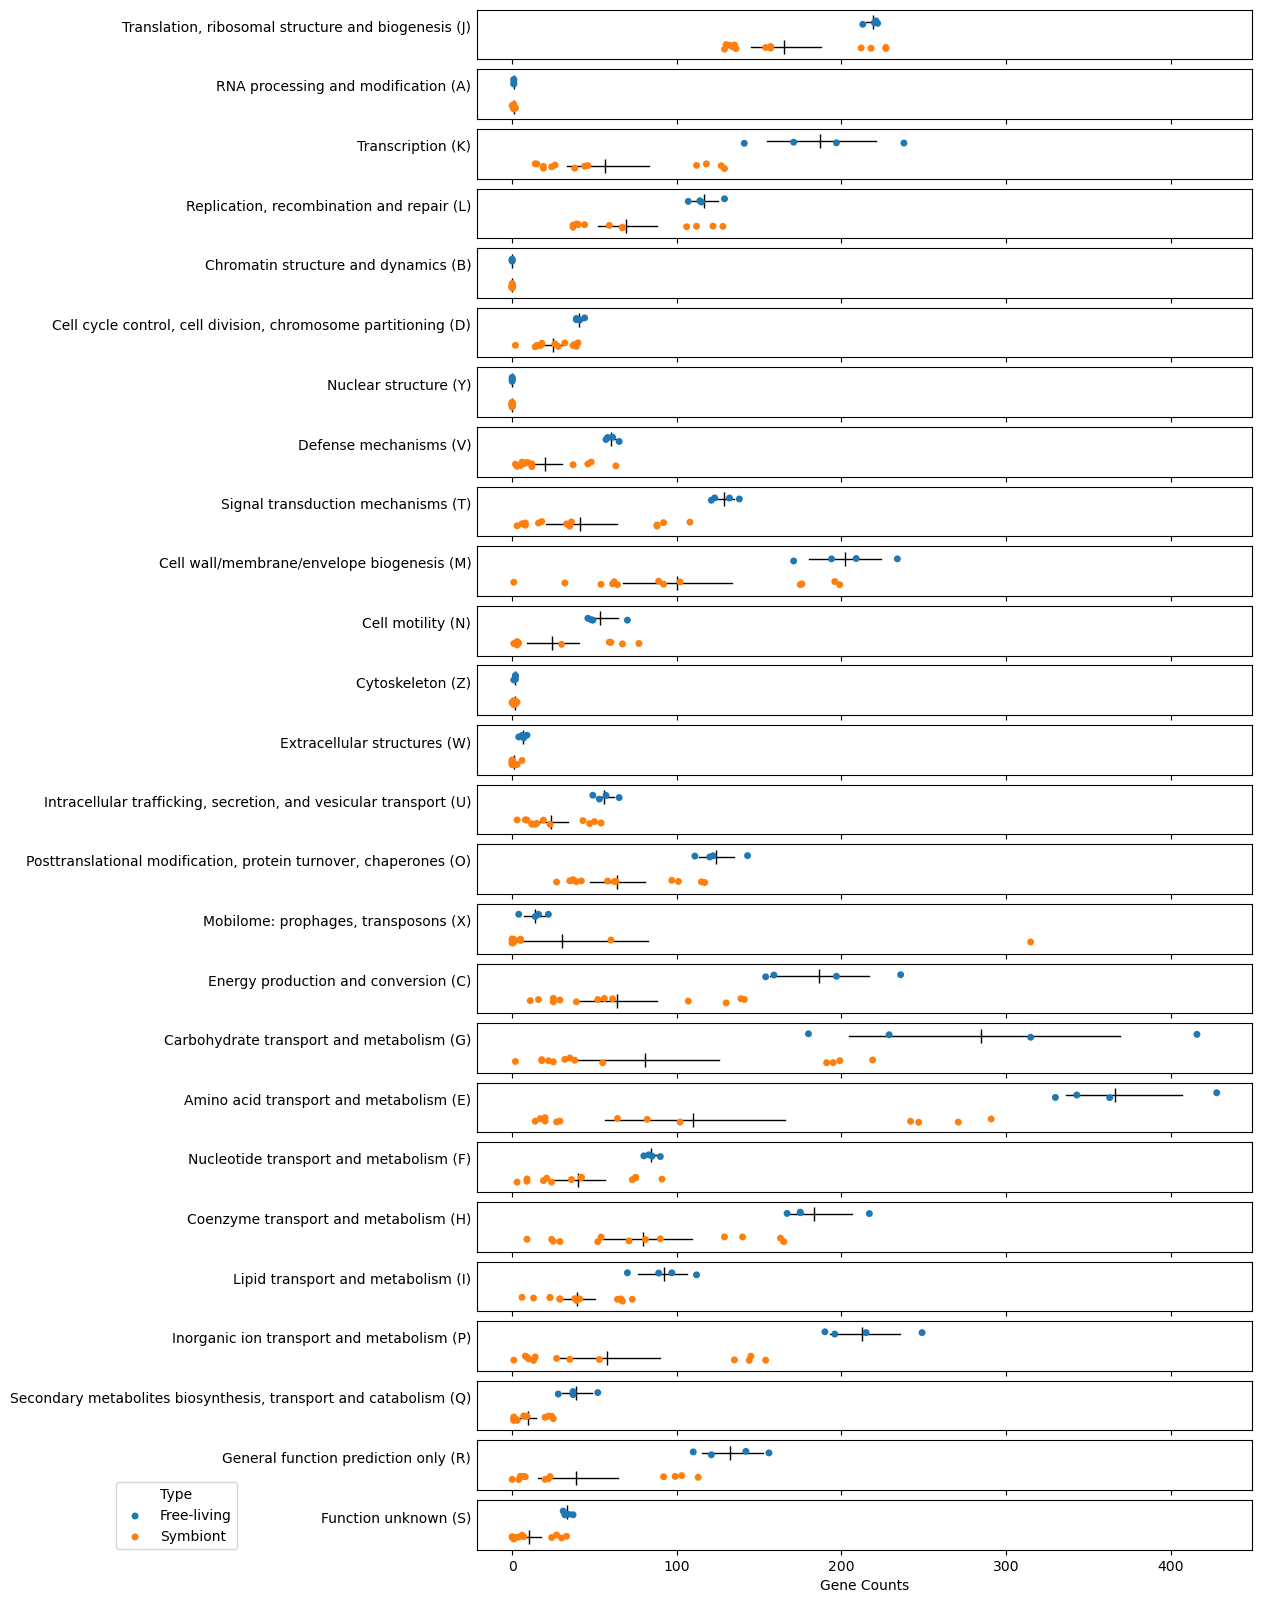

In [153]:
fig, axes = plt.subplots(len(categories), 1, figsize = (10,20), sharex=True)
for i in range(len(categories)):
    sns.stripplot(data=counts,y="is_endosymb",x=categories[i], hue="is_endosymb", ax = axes[i])
    sns.pointplot(data=counts,y="is_endosymb",x=categories[i],linestyle="none",errorbar="ci",marker="|",markersize=10,markeredgewidth=1,ax=axes[i],color="black", err_kws={'linewidth':1})

    axes[i].set_ylabel(cog_cats["CATEGORY_DESCRIPTION"][i] + " (" + categories[i] + ")", rotation=0, horizontalalignment="right")
    axes[i].set_xlabel("Gene Counts")
    axes[i].set_yticks([])

axes[-1].legend(["Free-living", "Symbiont"], title="Type", bbox_to_anchor=(-0.3, 1.5))
plt.tight_layout
plt.savefig("figures/gene_counts.pdf", bbox_inches="tight")
plt.show()

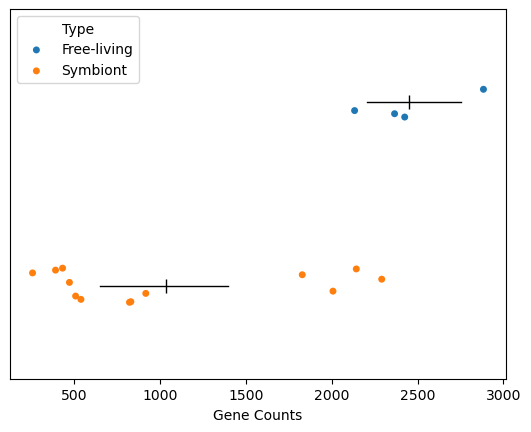

In [167]:
fig, axes = plt.subplots(1,1)

sns.stripplot(data=counts,y="is_endosymb",x="Total", hue="is_endosymb", ax = axes)
sns.pointplot(data=counts,y="is_endosymb",x="Total",linestyle="none",errorbar="ci",marker="|",markersize=10,markeredgewidth=1,ax=axes,color="black", err_kws={'linewidth':1})

axes.set_ylabel("")
axes.set_xlabel("Gene Counts")
axes.set_yticks([])

axes.legend(["Free-living", "Symbiont"], title="Type", loc="upper left")
plt.tight_layout
plt.savefig("figures/gene_counts_total.pdf", bbox_inches="tight")
plt.show()

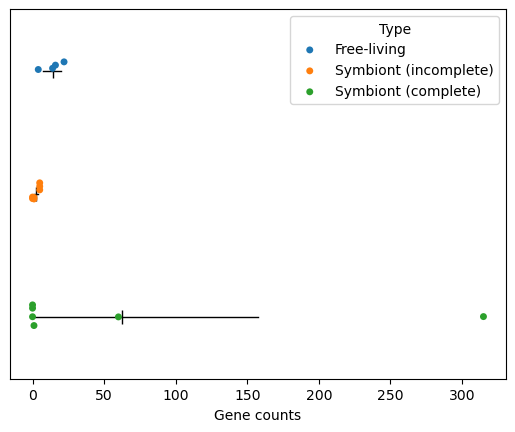

In [168]:
fig, axes = plt.subplots(1, 1)

sns.stripplot(data=counts,y="Type",x="X", hue="Type", ax = axes)
sns.pointplot(data=counts,y="Type",x="X",linestyle="none",errorbar="ci",marker="|",markersize=10,markeredgewidth=1,ax=axes,color="black", err_kws={'linewidth':1})
axes.set(xlabel="Gene counts", ylabel="")
axes.set_yticks([])

axes.legend(["Free-living", "Symbiont (incomplete)", "Symbiont (complete)"], title="Type", loc='upper right')
plt.tight_layout
plt.savefig("figures/mobilome_gene_counts.pdf")
plt.show()

No genes are found relating to chromatin structure and dynamics (B) or nuclear structure (Y), which makes sense given we are looking at bacteria. 
Only a few genes related to RNA processing & modification (A), the cytoskeleton (Z) and extracellular structures (W) are found. It would be interesting to look at which genes this precisely are, and see if that tells us anything.
Free-living species consistently have more genes than the symbiotic species, but there are constantly a few symbiotic species with similar high gene counts. The only exception is gene relating to the mobilome, here the symbiotic species S. glossinidius morsitans and S. pierantonius have a lot more genes than all other species.

In [163]:
outliers = {}
for cat in categories:
    mean = counts.loc[counts['is_endosymb'] == "Yes", cat].mean()
    std = counts.loc[counts['is_endosymb'] == "Yes", cat].std()
    count = counts.loc[counts['is_endosymb'] == "Yes", cat].count()
    outlier_from = mean + 1.96*std/math.sqrt(count)
    outliers_cat = counts.loc[(counts[cat] >= outlier_from) & (counts["is_endosymb"] == "Yes"), "Species"]
    for outlier in outliers_cat:
        outliers[outlier] = outliers.get(outlier, 0) + 1
#    print("Outliers in " + cat + ":", list(outliers_cat))
    
mean = counts.loc[counts['is_endosymb'] == "Yes", "Total"].mean()
std = counts.loc[counts['is_endosymb'] == "Yes", "Total"].std()
count = counts.loc[counts['is_endosymb'] == "Yes", "Total"].count()
outlier_from = mean + 1.96*std/math.sqrt(count)
outliers_cat = counts.loc[(counts["Total"] >= outlier_from) & (counts["is_endosymb"] == "Yes"), "Species"]
print("Outliers in total gene count:", list(outliers_cat))
#for outlier in outliers_cat:
#    outliers[outlier] = outliers.get(outlier, 0) + 1

print("Number of times a species is an outlier in a category: ", outliers)

Outliers in total gene count: ['Sodalis_endolongispinus_SOD1', 'Sodalis_glossinidius_morsitans', 'Sodalis_pierantonius_SOPE', 'Sodalis_sp_TME1']
Number of times a species is an outlier in a category:  {'Sodalis_endolongispinus_SOD1': 23, 'Sodalis_glossinidius_morsitans': 23, 'Sodalis_pierantonius_SOPE': 24, 'Sodalis_sp_TME1': 22, 'Sodalis_sp_HBA': 3, 'Doolittlea_endobia_DEMHIR': 2, 'Gullanella_endobia_GEFVIR': 2, 'Mikella_endobia_mEPMAR': 2, 'Moranella_endobia': 2, 'Sodalis_sp_CWE': 2, 'Sodalis_sp_EtF2': 2, 'Sodalis_sp_PSPU': 3, 'Sodalis_sp_SPI-1': 3}


Determine the symbiotic species with a number of genes in a certain category beyond a CI of 95%. We can see that S. endolongispinus, S. glossinidius morsitans, S. pierantonius and S. sp TME1 in particular have consistently more genes than expected of symbiotic species, and are more like the free-living species.